<h1><center> Time Series Analysis </center></h1>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.mlab as mlab
import math
from scipy.stats import norm
import statsmodels.graphics.tsaplots as tsa

<h3><center> - Données “Syndromes grippaux” - </center></h3>

1. Importez les données du fichier Openhealth_S-Grippal.csv. Consultez http://www.openhealth.fr/suivi-epidemiologique-temps-reel/ias-incidence-des-syndromes-grippaux pour plus
d’information sur les données. Affichez les 5 premières lignes du jeu de données. On va travailler
seulement avec la variable IAS_brut, sous la forme d’une série temporelle, dont on précisera la
fréquence d’échantillonage et les dates de début et de fin. Pour cette variable, dans ce jeu de données, les cas de nullité correspondent à des données manquantes. Combien de données manquantes
comporte-t-elle ? Pour les traitements des questions suivantes, éliminez les données manquantes par
imputation, c’est-à-dire en déduisant une valeur plus “raisonnable” aux dates non-observées à partir
des valeurs aux dates observées : par exemple par la moyenne de deux dates les plus proches.

In [2]:
df = pd.read_csv("Openhealth_S-Grippal.csv", delimiter=";", encoding="latin-1", decimal=",", na_values=0)

In [222]:
df.head()

,PERIODE,IAS_brut,IAS_lissé,Incidence_Sentinelles
0,2009-07-01,1.7,2.2,2.3
1,2009-07-02,3.4,2.1,2.3
2,2009-07-03,2.1,2.1,2.3
3,2009-07-04,1.3,2.0,2.3
4,2009-07-05,14.2,2.0,2.3


In [223]:
df.describe()

,IAS_brut,IAS_lissé,Incidence_Sentinelles
count,3477.000000,3486.000000,3442.000000
mean,267.975755,34.188067,12.127048
std,2412.997547,109.706852,21.381495
min,0.100000,0.200000,0.100000
25%,1.200000,1.100000,0.900000
50%,3.400000,2.700000,2.900000
75%,22.800000,10.100000,10.100000
max,71851.800000,1082.800000,118.100000


On peut vérifier les valeurs manquantes :

Il existe 9 valeurs manquantes :

In [224]:
df['IAS_brut'].isnull().sum()

9

Une interpolation linéaire est choisie pour les valeurs manquantes :

In [225]:
df['IAS_brut'] = df['IAS_brut'].interpolate()

2. Tracez la série temporelle considérée en fonction du temps. Commentez brièvement ce que vous
observez.

In [226]:
df['PERIODE'] = pd.to_datetime(df['PERIODE'])

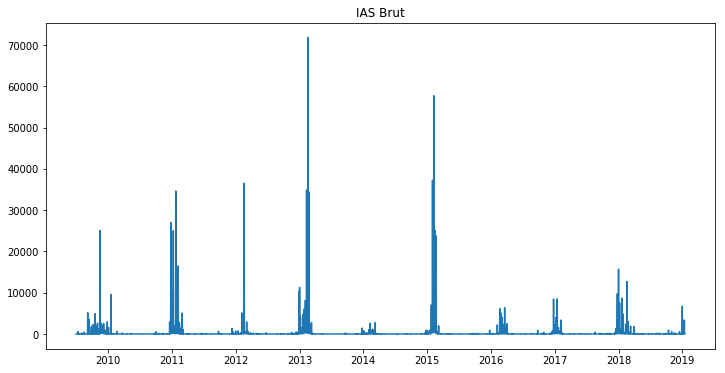

In [44]:
plt.figure(figsize=(12,6))
plt.plot(df['PERIODE'].values, df['IAS_brut'].values)
plt.title("IAS Brut")
plt.show()

3. Tracez l’histogramme de la loi marginale. Quel impact la distribution observée par l’histogramme
a sur la trajectoire représentée à la question précédente ?

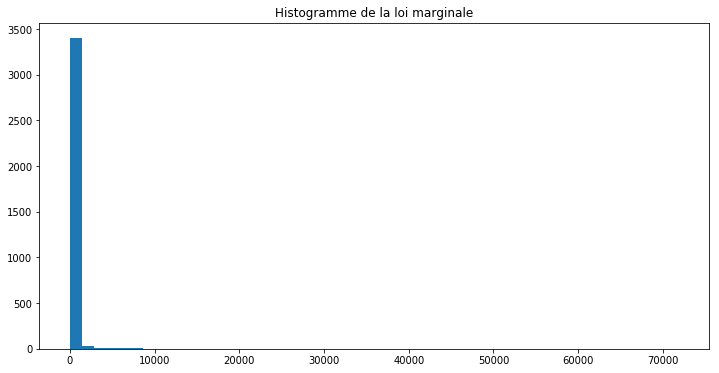

In [61]:
plt.figure(figsize=(12,6))
plt.hist(df['IAS_brut'], bins=50)
plt.title("Histogramme de la loi marginale")
plt.show()

4. Reprenez les questions précédentes après tranformations des observations par le logarithme naturel.
Commentez.

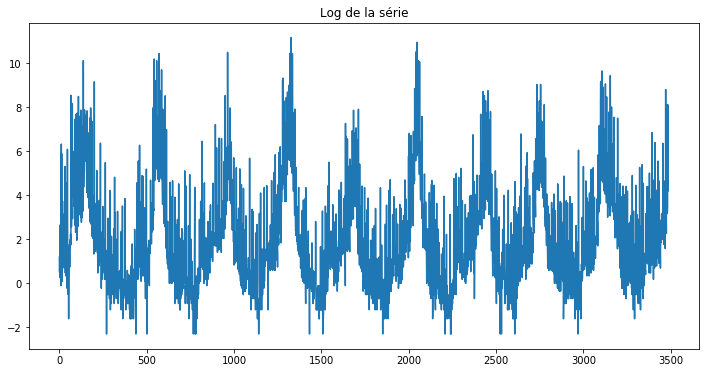

In [58]:
plt.figure(figsize=(12,6))
plt.plot(np.log(df['IAS_brut']))
plt.title("Log de la série")
plt.show()

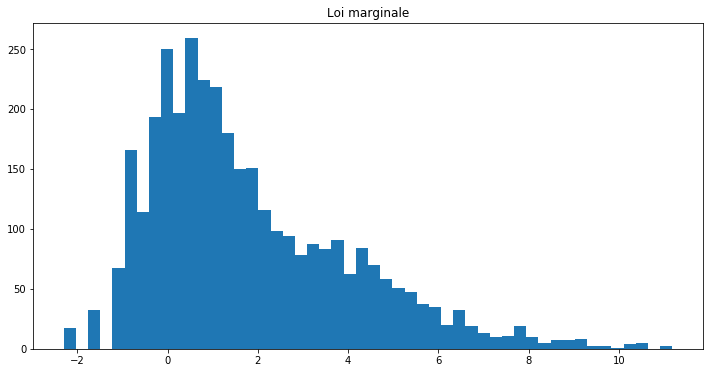

In [56]:
plt.figure(figsize=(12,6))
plt.hist(np.log(df['IAS_brut']), bins=50)
plt.title("Loi marginale")
plt.show()

5. En utilisant signal.perodogram() (du package signal importé depuis scipy), tracez le périodogramme des données. Expliquez les pics les plus significatifs que vous observez. Attention au fait
que dans la communauté signal les spectres sont normalisées pour des fréquences absolues dans
[−1/2, 1/2] plutôt que [−π, −π].

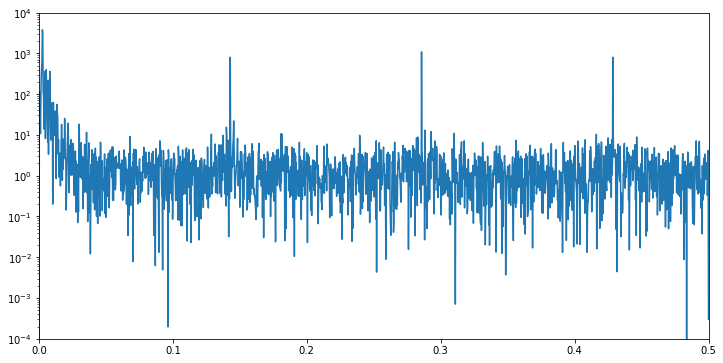

In [89]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(np.log(df['IAS_brut']))
plt.semilogy(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

Les pics correspondent aux valeurs qui ne sont pas expliquées par le bruit de fond.

6. Pour supprimer une tendance périodique de période T dans un signal (xt)t∈Z il suffit d’appliquer
le filtre ∆T défini par
[∆T x]t = xt − xt−T
Utilisez cette méthode pour supprimer la tendance périodique de période 1 an. Quel pic du périodogramme cette méthode a fait disparaître ?

In [97]:
time_diff = []
for i in range(365, len(df)) :
    time_diff.append(np.log(df.loc[i]['IAS_brut']) - np.log(df.loc[i-365]['IAS_brut']))

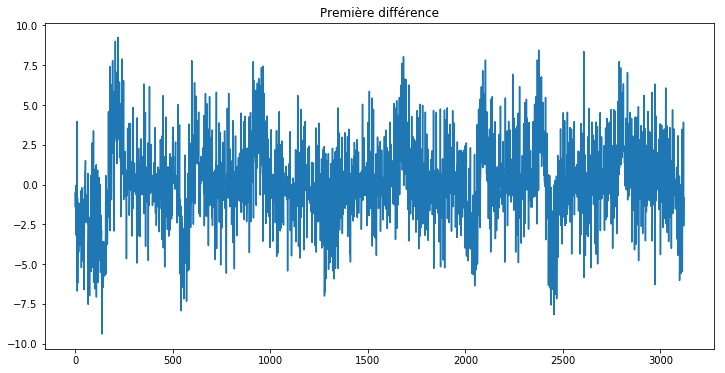

In [98]:
plt.figure(figsize=(12,6))
plt.plot(time_diff)
plt.title("Première différence")
plt.show()

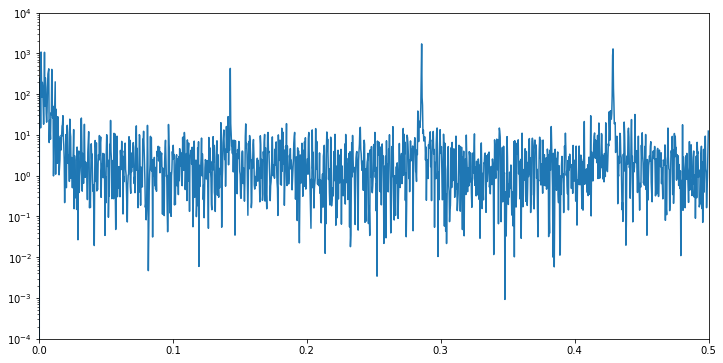

In [105]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(time_diff)
plt.semilogy(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-4, 1e+4])
plt.show()

Quelques pics ont disparu.

7. On vous propose un exercise de prédiction uniquement à partir de la tendance périodique. On va
prédire les valeurs de IAS_brut pour les dates du 1er avril 2013 au 17 avril 2014 en se basant
sur les observations précédentes (du 1er juillet 2009 au 31 mars 2013) pour estimer la tendance
périodique des données. Pour cela, pour un nombre d’harmoniques fixé (disons n_harm), construisez
les variables explicatives pour la période d’apprentissage : pour chaque k = 1, 2, ... n_harm, ajoutez
deux variables explicatives, xi,2k−1 = cos(ti
· k ·
2π / T
) et xi,2k = sin(ti
· k ·
2π / T
), où ti est le moment
de temps (on peut utiliser les nombres entiers au lieu de dates) et T = 365. 

In [279]:
n_harm = 5

In [280]:
X = df.copy()
X['index'] = X.index

In [281]:
X.head()

,PERIODE,IAS_brut,IAS_lissé,Incidence_Sentinelles,index
0,2009-07-01,1.7,2.2,2.3,0
1,2009-07-02,3.4,2.1,2.3,1
2,2009-07-03,2.1,2.1,2.3,2
3,2009-07-04,1.3,2.0,2.3,3
4,2009-07-05,14.2,2.0,2.3,4


In [282]:
for k in range(1, n_harm) :
    X['add_cos' + str(k)] = np.cos(X['index'] * k * 2 * math.pi / 365)
    X['add_sin' + str(k)] = np.sin(X['index'] * k * 2 * math.pi / 365)

In [283]:
X_train = X[X['PERIODE'] < "2013-03-31"].drop(['IAS_lissé', 'Incidence_Sentinelles'], axis=1)
X_test = X[X['PERIODE'] >= "2013-03-31"].drop(['IAS_lissé', 'Incidence_Sentinelles'], axis=1)

In [284]:
X_train.head()

,PERIODE,IAS_brut,index,add_cos1,add_sin1,add_cos2,add_sin2,add_cos3,add_sin3,add_cos4,add_sin4
0,2009-07-01,1.7,0,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,2009-07-02,3.4,1,0.999852,0.017213,0.999407,0.034422,0.998667,0.051620,0.997630,0.068802
2,2009-07-03,2.1,2,0.999407,0.034422,0.997630,0.068802,0.994671,0.103102,0.990532,0.137279
3,2009-07-04,1.3,3,0.998667,0.051620,0.994671,0.103102,0.988023,0.154309,0.978740,0.205104
4,2009-07-05,14.2,4,0.997630,0.068802,0.990532,0.137279,0.978740,0.205104,0.962309,0.271958


Estimez la tendance périodique en régressant les données d’apprentissage sur ces variables explicatives.

In [285]:
y_train = X_train['IAS_brut']
X_train = X_train.drop(['IAS_brut', 'PERIODE'], axis=1)

In [286]:
est = sm.OLS(y_train, X_train).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               IAS_brut   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     7.598
Date:                Fri, 18 Jan 2019   Prob (F-statistic):           6.18e-11
Time:                        10:57:44   Log-Likelihood:                -12925.
No. Observations:                1369   AIC:                         2.587e+04
Df Residuals:                    1360   BIC:                         2.591e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.4587      0.106      4.347      0.0

Avec ce modèle linéaire, prédisez les valeurs du variable IAS_brut pour la période du 1er avril 2013
au 17 avril 2014.

In [287]:
y_test = X_test['IAS_brut']
X_test = X_test.drop(['PERIODE', 'IAS_brut'], axis = 1)
pred = est.predict(X_test)
pred.head()

1369    167.880169
1370    146.549898
1371    126.989343
1372    109.204289
1373     93.194313
dtype: float64

Tracez les valeur de la série temporelle et votre prédiction pour l’ensemble de données (vous pouvez
utilisez les couleurs différentes pour pour les partie apprentissage et prédiction).

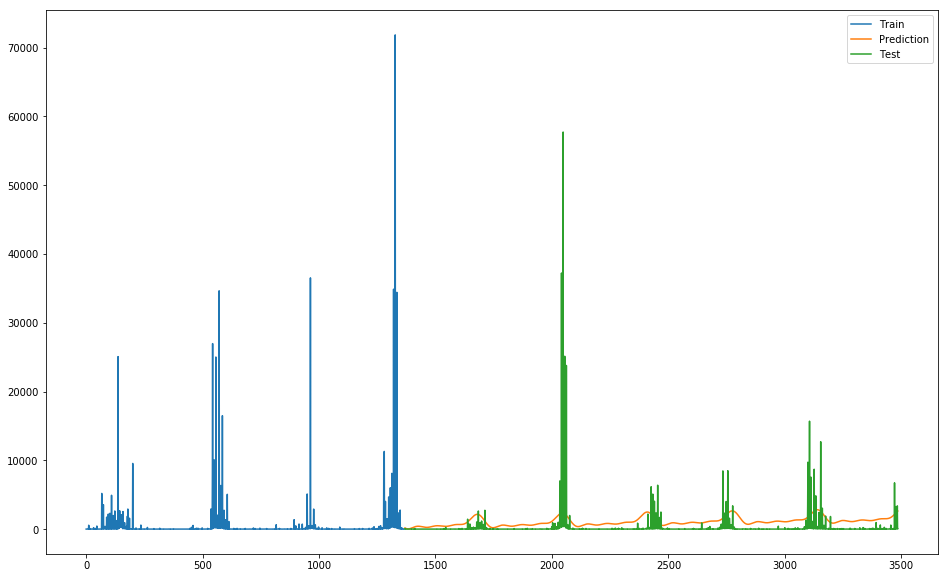

In [288]:
plt.figure(figsize=(16,10))
plt.plot(y_train, label="Train")
plt.plot(pred, label="Prediction")
plt.plot(y_test, label="Test")
plt.legend()
plt.show()

Puis, donnez le risque quadratique de la prédiction et tracez les résidus pour la période prédite.

In [289]:
quad_risk = sum((y_test - pred)**2)
quad_risk

8773114706.7557

In [290]:
residuals = y_test - pred

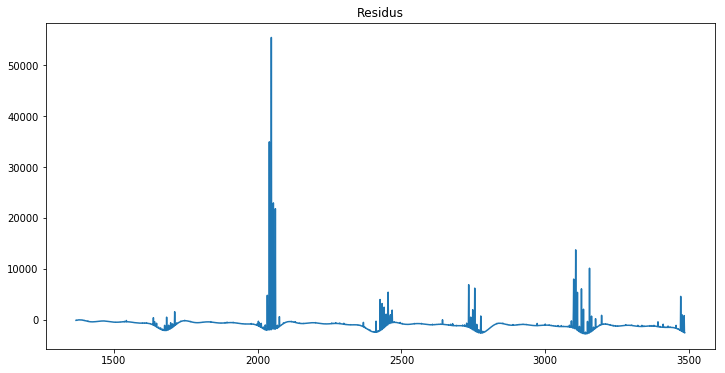

In [291]:
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.title("Residus")
plt.show()

Essayez les valeur de n_harm pour voir comment varie le risque quadratique de la prédiction.

Plus n_harm est élevé, plus la forme de la prédiction sera complexe. Il y a un optimum vers 5.

<h3><center> - Données “Trafic internet” - </center></h3>

1. Importez les données du fichier lbl-tcp-3.tcp. Chaque ligne du tableau correspond à un paquet et la première variable et le moment de sa transmission ; consultez http://ita.ee.lbl.gov/html/contrib/LBL-TCP-3.html pour plus d’information sur les données. Affichez 5 premières lignes du jeu de données.

In [79]:
col_names = ["timestamp", "sourceHost", "destinationHost", "sourceTCPPort", "destinationTCPPort", "bytes"]

In [80]:
df = pd.read_csv("lbl-tcp-3.tcp", delimiter=" ", names = col_names, header=None)

In [81]:
df.head()

,timestamp,sourceHost,destinationHost,sourceTCPPort,destinationTCPPort,bytes
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


Tout d’abord, créez la série temporelle, où chaque observation correspond au nombre de paquets
transmis dans un intervalle de 10 secondes. Il y a 720 intervalles, donc vous devez obtenir 720
observations. Tracez la série temporelle obtenue

"The trace ran from 14:10 to 16:10 on Thursday, January 20, 1994 (times are Pacific Standard Time), capturing 1.8 million TCP packets (about 0.0002 of these were dropped). The tracing was done on the Ethernet DMZ network over which flows all traffic into or out of the Lawrence Berkeley Laboratory, located in Berkeley, California. The raw trace was made using tcpdump on a Sun Sparcstation using the BPF kernel packet filter. Timestamps have microsecond precision."

In [82]:
df['index'] = df.index

In [83]:
df['timedelta'] = df['timestamp'].map(lambda x : datetime.timedelta(x))

In [84]:
df.at[0, 'timedelta'] = 0

In [85]:
df['timedelta'] = df['timedelta']/86400

In [86]:
df.head()

,timestamp,sourceHost,destinationHost,sourceTCPPort,destinationTCPPort,bytes,index,timedelta
0,7.591038e+08,1,2,23,2436,1,0,0
1,1.044500e-02,2,1,2436,23,2,1,0:00:00.010445
2,2.377500e-02,1,2,23,2436,2,2,0:00:00.023775
3,2.655800e-02,2,1,2436,23,1,3,0:00:00.026558
4,2.900200e-02,3,4,3930,119,42,4,0:00:00.029002


In [87]:
i = 0
bytes_cum_array = []
#time_cum = 0
bytes_cum=0

for index in range(1, len(df)-1) :
    if index > 0 :
        time_cum = df.loc[index, 'timedelta'].total_seconds() - len(bytes_cum_array) * 10
        bytes_cum = bytes_cum + df.loc[index, 'bytes']
        if time_cum >= 10 :
            bytes_cum_array.append(bytes_cum)
            bytes_cum=0

In [88]:
df = pd.DataFrame(bytes_cum_array, columns=['bytes'])

In [89]:
df['time'] = df.index

In [90]:
df.head()

,bytes,time
0,100180,0
1,128214,1
2,657071,2
3,165290,3
4,257638,4


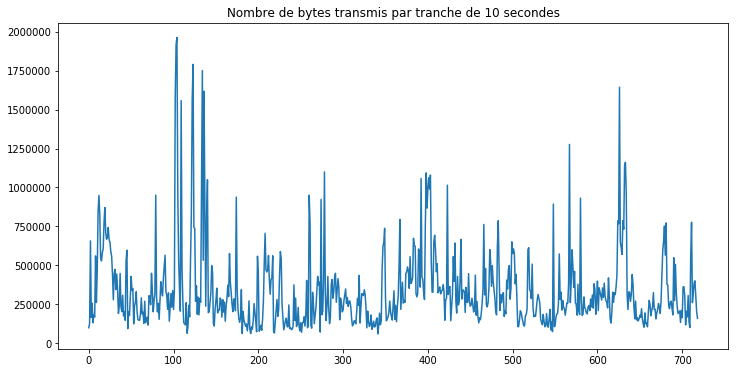

In [19]:
plt.figure(figsize=(12,6))
plt.plot(df['time'], df['bytes'])
plt.title("Nombre de bytes transmis par tranche de 10 secondes")
plt.show()

9. Dans cette question on vous propose de construire un modèle auto-régressif AR(p). L’apprentissage
du modèle ne demande pas beaucoup de temps et s’effectue avec 1 − 2 ligne de code à l’aide
de la fonction ARIMA() importée de statsmodels.tsa.arima_model. Le choix du paramètre p
(d’une gamme de valeur prédéfinies, disons de 1 à pmax) est moins simple. On va aborder trois
possibilité : critère d’information d’Akaike (AIC), critère d’information bayésien (BIC) et validation
croisée/backtesting.

In [91]:
 df = df.set_index('time')

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

                              ARMA Model Results                              
Dep. Variable:                  bytes   No. Observations:                  501
Model:                    ARMA(10, 0)   Log Likelihood               -6874.167
Method:                       css-mle   S.D. of innovations         220011.070
Date:                Fri, 18 Jan 2019   AIC                          13772.333
Time:                        17:21:08   BIC                          13822.932
Sample:                             0   HQIC                         13792.186
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         3.514e+05   3.01e+04     11.657      0.000    2.92e+05     4.1e+05
ar.L1.bytes      0.5488      0.045     12.306      0.000       0.461       0.636
ar.L2.bytes      0.0349      0.051      0.68

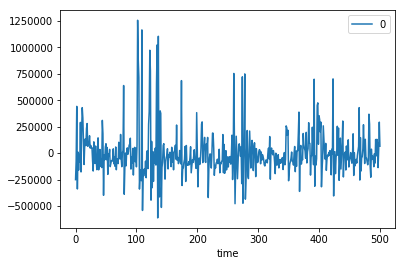

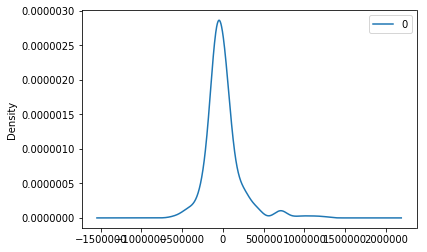

                  0
count  5.010000e+02
mean   4.578561e+02
std    2.203548e+05
min   -6.129548e+05
25%   -1.040042e+05
50%   -3.416967e+04
75%    5.952005e+04
max    1.256218e+06


In [21]:
arima = ARIMA(df.loc[:500], order=(10,0,0))
arima = arima.fit()
print(arima.summary())

# plot residual errors
residuals = pd.DataFrame(arima.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()

print(residuals.describe())

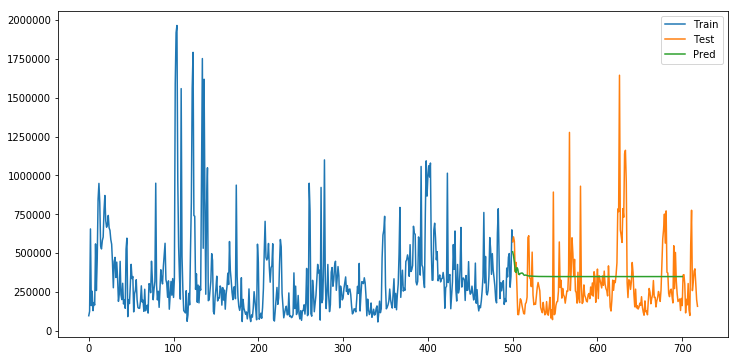

In [23]:
plt.figure(figsize=(12,6))
plt.plot(df.loc[:500], label="Train")
plt.plot(df.loc[500:], label="Test")
plt.plot(arima.predict(start=500, end=700),label="Pred")
plt.legend()
plt.show()

Le critères d’information AIC et BIC sont normalement implémentés dans le logiciel et sont donnés
directement après l’apprentissage du modèle. Pour faire la validation croisée pour une série, on la
coupe en nchunks chunks/folds et chaque fois utilise k premiers chunks pour entrainer le modèle et
le chunk numéro k + 1 pour le tester (par exemple regarder le risque quadratique). Pour une gamme de valeur choisie, effectue les trois méthodes de la sélection du modèle.

In [24]:
number = 5

In [25]:
k = 0
mse_t = []
tot = len(df)
for i in range(1,number) :
    k = k + int(tot/number)
    model = ARIMA(df.loc[:k], order=(5,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(start=k, end=tot)
    mse_t.append(mean_squared_error(pred, df.loc[k-1:]))

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

In [26]:
np.mean(mse_t)

49551794478.21069

10. En se basant sur les résultats de la question précédente, sélectionnez l’ordre p du modèle AR à
estimer et affichez les paramètres correspondants.
Tracez les résidus. Tracez l’estimation de la densité de résidus et la densité de la distribution
normale (avec moyenne et écart-type estimés) sur le même graphique et comparez les visuellement.
Commentez.

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

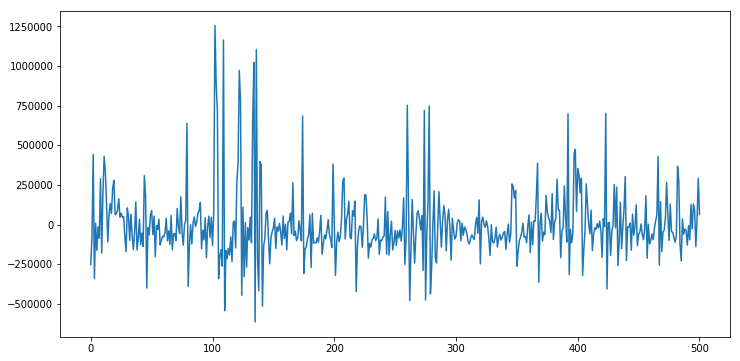

In [92]:
arima = ARIMA(df.loc[:500], order=(10,0,0))
arima = arima.fit()

# plot residual errors
residuals = pd.DataFrame(arima.resid)
plt.figure(figsize=(12,6))
plt.plot(residuals)
plt.show()

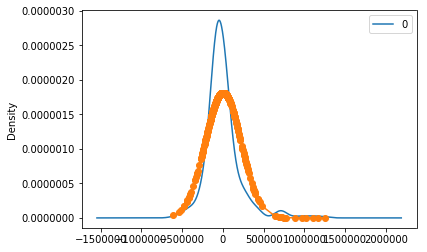

In [99]:
h = residuals.sort_values(0)
fit = stats.norm.pdf(h, np.mean(h), np.std(h))
residuals.plot(kind='kde')
plt.plot(h,fit,'-o')
plt.show()

<h3><center> - Données “Southern Oscillation Index” - </center></h3>

11. Importez les données du fichier soi.tsv. Consultez http://www.bom.gov.au/climate/glossary/soi.shtml pour plus d’information sur les données. Supprimez les données manquantes.

In [103]:
df = pd.read_csv("soi.tsv", delimiter="\t", header=None).T
df.head()

,0
0,1.537160
1,0.922168
2,-0.104204
3,-0.291903
4,-0.658745


In [104]:
df = df.dropna()

12. A l’aide des fonctions plot_acf() et plot_pacf() importées de statsmodels.graphics.tsaplots,
tracez la fonction d’autocorrélation et la fonction d’autocorrélation partielle.

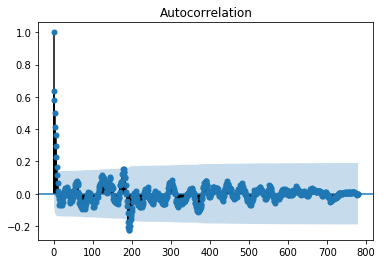

In [18]:
tsa.plot_acf(df);

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


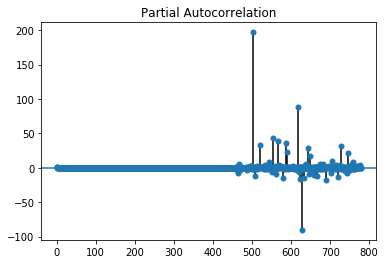

In [19]:
tsa.plot_pacf(df);

13. En se basant sur la question précédente, choisissez l’ordre du processus auto-régressive AR(p).
Entrainer le modèle AR choisi.

L'autorrelation partielle est significative jusqu'à environ un ordre de 11. 

In [33]:
model = ARMA(df, order=(11,0))
result = model.fit()

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      0   No. Observations:                  780
Model:                    ARMA(11, 0)   Log Likelihood                -817.296
Method:                       css-mle   S.D. of innovations              0.690
Date:                Sun, 20 Jan 2019   AIC                           1660.591
Time:                        15:25:19   BIC                           1721.162
Sample:                             0   HQIC                          1683.888
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1324      0.086      1.539      0.124      -0.036       0.301
ar.L1.0        0.4156      0.036     11.615      0.000       0.345       0.486
ar.L2.0        0.2485      0.039      6.407      0.000       0.172       0.325
ar.L3.0        0.1009      0.040      2.534      0.011       0.023       0.179
ar.L4.0       -0.0079      0.040     -0.199      0.843      -0.086       0.070
ar.L5.0        0.0493      0.040      1.233      0.218      -0.029       0.128
ar.L6.0        0.0130      0.040      0.326      0.745      -0.065       0.091
ar.L7.0       -0.0127      0.040     -0.317      0.752      -0.091       0.066
ar.L8.0       -0.0221      0.040     -0.553      0.580      -0.101       0.056
ar.L9.0       -0.0128      0.040     -0.322      0.747      -0.091       0.065
ar.L10.0      -0.0084      0.039     -0.217      0.828      -0.085       0.068
ar.L11.0      -0.0498      0.036     -1.388      0.166      -0.120       0.021
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.1173           -0.1936j            1.1340           -0.0273
AR.2             1.1173           +0.1936j            1.1340            0.0273
AR.3             0.9100           -0.9918j            1.3460           -0.1318
AR.4             0.9100           +0.9918j            1.3460            0.1318
AR.5            -1.3781           -0.0000j            1.3781           -0.5000
AR.6            -1.1143           -0.7357j            1.3353           -0.4071
AR.7            -1.1143           +0.7357j            1.3353            0.4071
AR.8             0.2646           -1.3594j            1.3849           -0.2194
AR.9             0.2646           +1.3594j            1.3849            0.2194
AR.10           -0.5732           -1.2245j            1.3520           -0.3197
AR.11           -0.5732           +1.2245j            1.3520            0.3197
------------------------------------------------------------------------------
"""

Tracez les résidus. Tracez l’estimation de la densité de résidus et la
densité de la distribution normale (avec moyenne et écart-type estimés) sur le même graphique et
comparez les visuellement. Commentez.

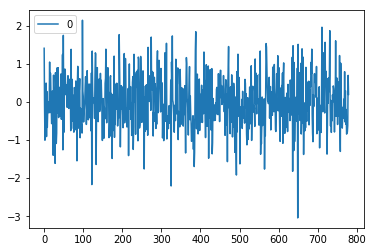

In [37]:
# plot residual errors
residuals = pd.DataFrame(result.resid)
residuals.plot()
plt.show()

In [76]:
h = residuals.sort_values(0)
fit = stats.norm.pdf(h, np.mean(h), np.std(h))

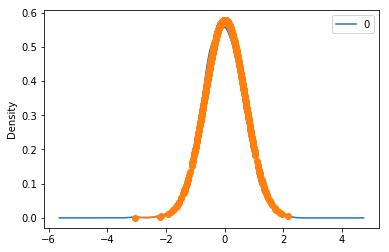

In [77]:
residuals.plot(kind='kde')
plt.plot(h,fit,'-o')
plt.show()

Les résidus sont distribués selon une loi normale.

14. Tracez le périodogramme ; superposez le à la densité spectrale du modèle estimé à la question
précédente. On utilisera qu’un modèle AR(p) de coefficients auto-régressifs φ1, . . . , φp satisfaisant
l’équation AR

<img src='data.png'>

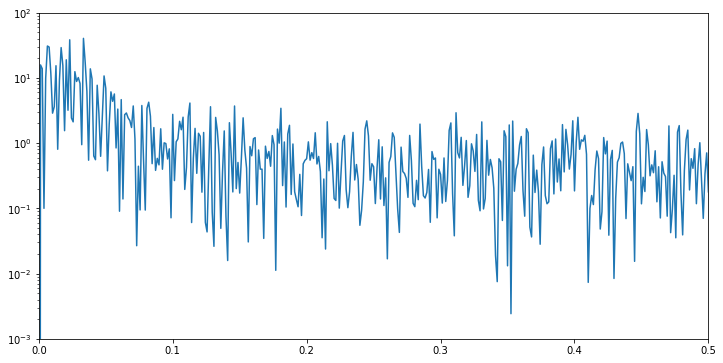

In [108]:
plt.figure(figsize=(12,6))
f, Pxx_den = signal.periodogram(df[0])
plt.semilogy(f, Pxx_den)
plt.xlim([1e-10, 0.5])
plt.ylim([1e-3, 1e+2])
plt.show()